# Análisis Series de Tiempo

Este análisis se desarrolló usando la información que descargamos del API público de Twitter.

- Información del: **2019-10-20 al: 2019-11-05**.
- **4.807.736** de tweets.
- **638.893** usuarios.
- Las búsquedas se realizaron en base a los principales **hashtags**:

> ['cambiodegabinete', 'renunciapinera', 'chiledesperto',
> 'lamarchamasgrandedechile', 'chilesecanso', 'chilequierecambios',
> 'pinerarenuncia', 'prensaprostituida', 'toquedequedachile',
> 'superlunes', 'lamarchamasgrandedetodas', 'pazparachile',
> 'noalaasambleaconstituyente', 'toquedequeda', 'nuevaconstitucion',
> 'chilenosquehablan', 'aguantesharp', 'nomasmarchas', 'fuerasharp',
> 'nomasviolencia', 'fueracomunistas', 'pineralies', 'evasionmasiva',
> 'pineraverguenzamundial', 'chilenoquieremigajas', 'pineramiente',
> 'noestamosenguerra', 'acusacionconstitucional', 'sinigualdadnohaypaz',
> 'losmilicosnosontusamigos', 'chileseaburrio', 'estadodeemergencia',
> 'chalecosamarillos', 'yotengopyme', 'karlarubilar',
> 'destitucionarticulo60','evasiontodoeldia',
> 'nuevaconstitucionparachile', 'nomasmarcha', 'fueracomunismodechile',
> 'chilepaisdepiromanos', 'militaresalacalleya', 'nomasencapuchados',
> 'izquierdagolpista', 'toquedequedatotal', 'nuevaconstitucionahora',
> 'renunciasharp', 'chileenreveldia', 'toquedequedaahora',
> 'metroselevanta', 'chiledepie', 'nomassocialismo',
> 'nomasdelincuencia', 'nomastag', 'evasionmetro', 'pazporchile',
> 'votocastigo', 'destitucionahora', 'plebicito15d']

Estos tweets se agruparon para realizar el análisis de serie de tiempo y buscar anomalía o comportamientos extraños.


## Importamos las librerías

In [15]:
import os
import time

import pandas as pd

from wordcloud import WordCloud
from collections import Counter

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

%matplotlib inline

## Cargamos la data

- **ds**: Datetime, la hora redondeada a 1 minuto.
- **y**: Int, la cantidad de tweets en ese minuto.

In [8]:
# Cargamos la data
time_series = pd.read_pickle('data/time_series_data.pickle')
time_series.sample(3)

,ds,y
5705,2019-10-23 20:05:00,204
16480,2019-10-31 07:40:00,1
23615,2019-11-05 06:35:00,33


Vemos claramente que tenemos **24.480 muestras**, en promedio se generan **196** tweets por minuto, con un **máximo de 3.217 tweets por minuto**.

In [9]:
time_series.describe()

,y
count,24480.000000
mean,196.394444
std,232.538812
min,0.000000
25%,56.000000
50%,140.000000
75%,269.000000
max,3217.000000


## Detección de Anomalías

Para realizar este análisis vamos a utilizar **Facebook Prophet** una herramienta especializada en el análisis de series de tiempo.

> **Prophet** is a procedure for forecasting time series data based on an
> additive model where non-linear trends are fit with yearly, weekly,
> and daily seasonality, plus holiday effects. It works best with time
> series that have strong seasonal effects and several seasons of
> historical data. Prophet is robust to missing data and shifts in the
> trend, and typically handles outliers well.

In [17]:
m = Prophet(daily_seasonality=True, yearly_seasonality=False, weekly_seasonality=False,
            seasonality_mode='multiplicative', interval_width=0.99)

m = m.fit(time_series)
forecast = m.predict(time_series)
forecast['fact'] = time_series['y'].reset_index(drop = True)

Este primer gráfico nos permite ver que existen comportamiento anómalos, donde se producen más tweets por minuto que lo estimado por **Prophet**:

- Hay peaks que superan el promedio diario de Tweets hasta llegar a peaks que **superan los 3.000 tweets por minuto** el 2019-10-23.
- Estos peaks pueden generarse por **bot´s, esfuerzos concertados para difundir algún tipo de tema, o alguna noticia externa** que generó este comportamiento anómalo.

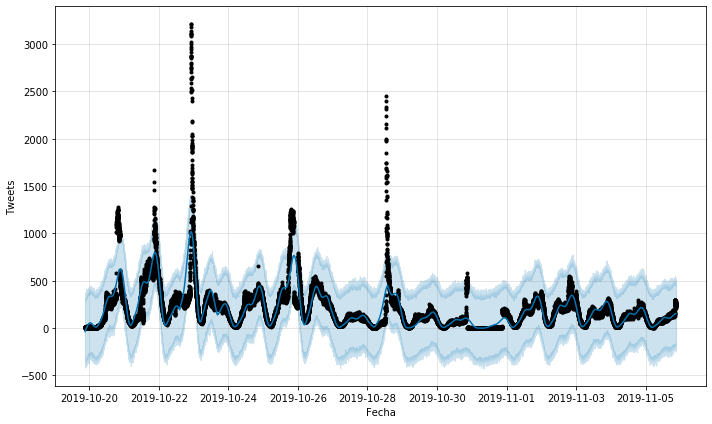

In [18]:
m.plot(forecast, xlabel='Fecha', ylabel='Tweets', uncertainty=True, plot_cap=True)
plt.show()

Este siguiente plot nos permite ver los momentos en los que se produjeron cambios de tendencia en la cantidad de tweets escritos por minuto.

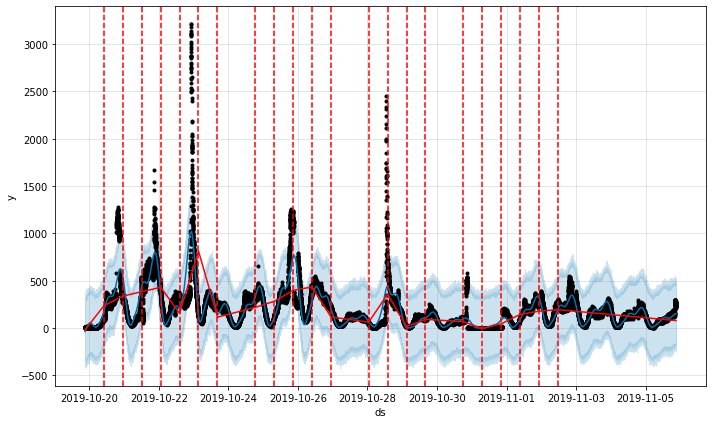

In [20]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Anomalía 1 | 2019-10-21

Se encontraron **15.781 tweets escritos que considerados anómalos** por el análisis de serie de tiempo, los principales hashtags utilizados fueron:

| Hashtag | Q Tweets |
|--|--|
| renunciapinera | 6215 |
| renunciapinera |  5648 |
| chiledesperto | 1965  |
| noestamosenguerra |  707 |

## Conclusiones